## INTRODUCTION

## IMPORT PACKAGES

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## PART 1: DATA SOURCES

In [41]:
login = pd.read_json('logins.json')

In [5]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### PART 1: BASIC EDA

In [21]:
login.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [22]:
login.describe()

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


#### PART 1: DATA WRANGLING

In [31]:
login.isnull().sum()

login_time    0
dtype: int64

There are no null values in the login data.

In [25]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

### PART 1: EXPLORATORY DATA ANALYSIS

Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [114]:
login.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [151]:
# convert the login_times to time_stamps
login['login_time'] = pd.to_datetime(login['login_time'])

In [152]:
login_1 = login.copy()

In [153]:
login_1.set_index('login_time', inplace=True)
login_1['count'] = login_1.index

In [154]:
login1 = login_1.sort_index().resample("15min").count()

In [155]:
login1.shape

(9788, 1)

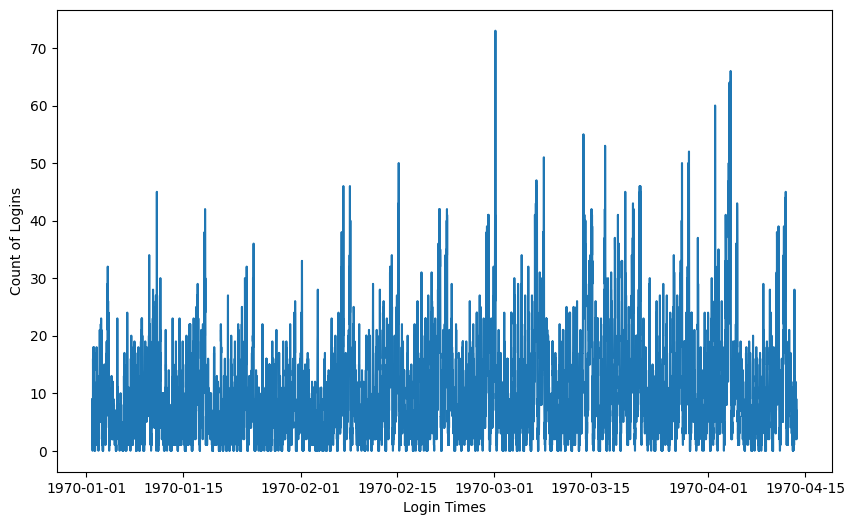

In [157]:
fig,ax = plt.subplots(figsize=(10,6))
#login1.plot(ax=ax)
plt.plot(login1)
plt.xlabel('Login Times')
plt.ylabel('Count of Logins')
plt.show()

We can readily recognize certain patterns in the peaks and valleys that appear to occur regularly each month. By closely observing the detailed fluctuations over a day, we can discern this pattern.

Let's use a window to have the data counts for the mean number of logins per day (given a day has 96 numbers of 15 mins intervals)

In [148]:
window = 96
login1_1day_window = login1['count'].rolling(window).mean()

In [149]:
login1_1day_window.dropna().head()

login_time
1970-01-02 19:45:00    6.125000
1970-01-02 20:00:00    6.177083
1970-01-02 20:15:00    6.208333
1970-01-02 20:30:00    6.250000
1970-01-02 20:45:00    6.312500
Freq: 15min, Name: count, dtype: float64

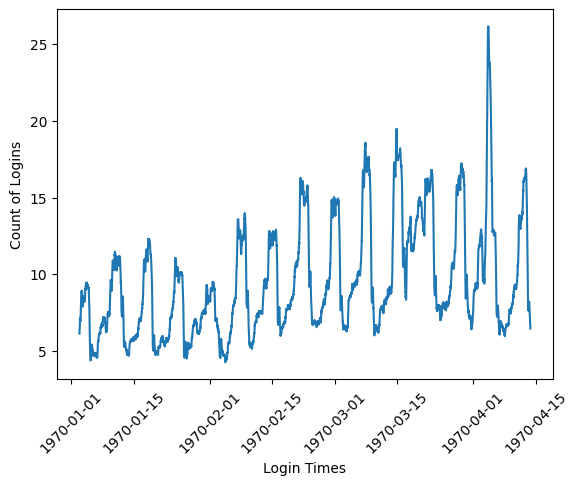

In [159]:
fig,ax = plt.subplots()
plt.plot(login1_1day_window.dropna())
plt.xlabel('Login Times')
plt.ylabel('Count of Logins')
plt.xticks(rotation=45)
plt.show()

Let's consider just one week:

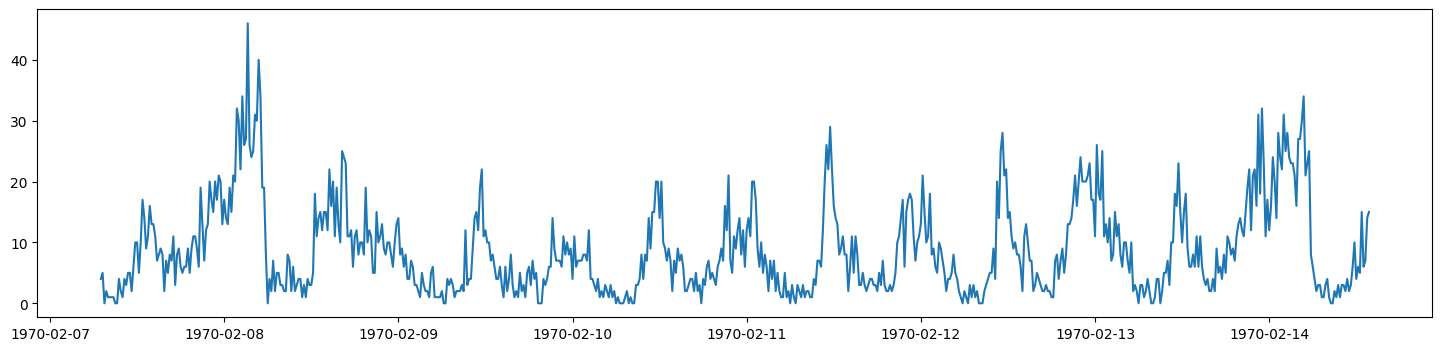

In [181]:
plt.figure(figsize = (18,4))
plt.plot(login1[3500:4200])

Observing the usage on a weekly basis tells us that peaks for the most part occur at an interval of every 12 hours.

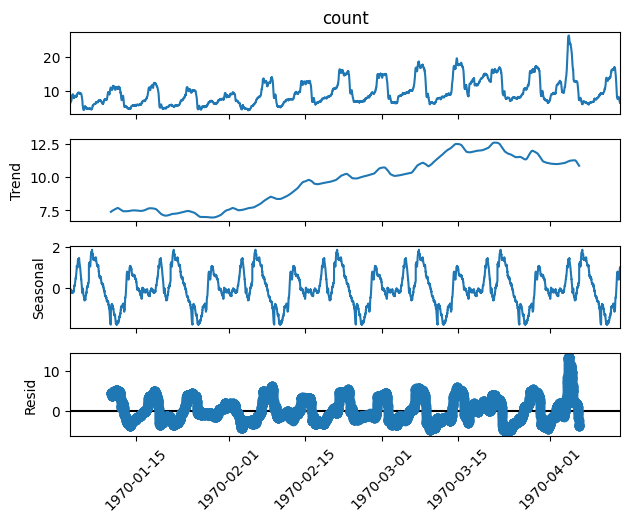

In [167]:
# time series decomposition
# https://stackoverflow.com/questions/36083832/valueerror-freq-t-not-understood-please-report-if-you-think-this-in-error-se
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(login1_1day_window.dropna(), period = 60*24)
# Plot the original data, the trend, the seasonality, and the residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig=decomposition.plot()
plt.xticks(rotation=45)
plt.show()

As shown in the above plot, the data shows seasonality. Is the timeseries stationary?

In [173]:
from statsmodels.tsa.stattools import adfuller
#results = adfuller(login1_1day_window.dropna())
results = adfuller(login1)
print(results)

(-10.337954309060454, 2.7323966542229267e-18, 38, 9749, {'1%': -3.431020942932955, '5%': -2.8618365160244372, '10%': -2.5669278303551253}, 56368.34584451129)


Low p-value means that we can reject the null hypothesis and therefore the null hypothesis based on augmented Dicky-Fuller test (time series is non-stationary) is rejected. Therefore, the time seris is stationary. This however contradicts with the results from the kpss method.

In [174]:
from statsmodels.tsa.stattools import kpss
#kpss(login1_1day_window.dropna(), regression='c', nlags='auto', store=False)
kpss(login1_1day_window.dropna())

C:\Users\srafi\AppData\Local\Temp\ipykernel_16136\270268324.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(login1_1day_window.dropna())


(3.9406408832485895,
 0.01,
 58,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data.

In [185]:
# max of the logins
login1['count'].max()

73

In [197]:
login1['dayofweek'] = login1.index.dayofweek

To see in which day of the week this maximum is happening:

In [196]:
login1[login1['count']==73]

,count,dayofweek
login_time,,
1970-03-01 04:30:00,73,6


Let's see which days of the week we have the highest logins.

In [194]:
login1.groupby('dayofweek')['count'].sum()

dayofweek
0     8823
1     9268
2    10339
3    11960
4    15208
5    19377
6    18167
Name: count, dtype: int64

Monday=0 and Sunday=6, therefore, there are more logins on the weekend than the weekdays!

## PART 2: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment


Answer to question 1: 

Answer to question 2: 

## PART 3: PREDICTIVE MODELING

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

#### PART 3: DATA BASIC EDA AND WRANGLING

In [244]:
ultimate_chall = pd.read_json('ultimate_data_challenge.json')

In [245]:
ultimate_chall.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [246]:
ultimate_chall.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [247]:
ultimate_chall.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


It seems that some data are missing for avg_rating_of_driver, 49604, and avg_rating_by_driver.

In [248]:
ultimate_chall.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [249]:
df = ultimate_chall.copy()

In [250]:
missing_percentages = pd.DataFrame({'Features': (df.isnull().sum()*100/len(df)).index, 'Percentage Missing (%)': (df.isnull().sum()*100/len(df)).values})

In [221]:
missing_percentages

,Features,Percentage Missing (%)
0,city,0.000
1,trips_in_first_30_days,0.000
2,signup_date,0.000
3,avg_rating_of_driver,16.244
4,avg_surge,0.000
5,last_trip_date,0.000
6,phone,0.792
7,surge_pct,0.000
8,ultimate_black_user,0.000
9,weekday_pct,0.000


##### Feature imputations:

In [251]:
# checking if we have any nulls in other columns for the columns with avg_rating_of_driver as null
othercolumnsnulls = {}
for column in df.columns:
    othercolumnsnulls[column] = df[df['avg_rating_of_driver'].isnull()][column].isnull().sum()
print(othercolumnsnulls)

{'city': 0, 'trips_in_first_30_days': 0, 'signup_date': 0, 'avg_rating_of_driver': 8122, 'avg_surge': 0, 'last_trip_date': 0, 'phone': 96, 'surge_pct': 0, 'ultimate_black_user': 0, 'weekday_pct': 0, 'avg_dist': 0, 'avg_rating_by_driver': 67}


In [252]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [253]:
df.fillna({'phone':'Others'}, inplace=True)

In [254]:
df.phone.unique()

array(['iPhone', 'Android', 'Others'], dtype=object)

In [257]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df[['avg_rating_of_driver', 'avg_rating_by_driver']])
df[['avg_rating_of_driver', 'avg_rating_by_driver']] = imp.transform(df[['avg_rating_of_driver', 'avg_rating_by_driver']])

In [258]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

##### Check for duplicated values

The following code gives the indexes of the dataframe where we have duplicated values

In [266]:
np.where(df.duplicated(keep=False)==True)

(array([  116,   332,  2608,  3134,  5958,  7836, 10624, 14990, 18057,
        26709, 29601, 34641, 36627, 39601, 42025, 45416], dtype=int64),)

In [268]:
# this will return the duplicated rows (note that the duplicated values for the boolean series return True
# to find the non-duplicated values we use ~ operation to change the duplicated to false)
bool_series = df.duplicated(keep=False)
df[bool_series]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
116,Winterfell,1,2014-01-10,5.000000,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
332,Astapor,1,2014-01-18,5.000000,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
2608,Astapor,1,2014-01-18,5.000000,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
3134,Astapor,1,2014-01-20,5.000000,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0
5958,Winterfell,1,2014-01-18,4.601559,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
7836,Astapor,1,2014-01-11,5.000000,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
10624,Winterfell,1,2014-01-18,5.000000,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
14990,Winterfell,1,2014-01-18,4.601559,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
18057,Astapor,1,2014-01-11,5.000000,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
26709,Winterfell,1,2014-01-01,4.601559,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0


In [269]:
df = df[~bool_series]

In [272]:
df.duplicated().sum()

0

In [273]:
df['ultimate_black_user'].unique()

array([ True, False])

In [291]:
### checking if the user is active by checking if the last trip date falls within 30 days after 6 months
from datetime import timedelta
for row in df.itertuples():
    tmp_signup = pd.Timestamp(row.signup_date)
    tmp_date = tmp_signup + pd.Timedelta('181D')
    tmp_pointer = tmp_date - pd.Timedelta('30D')
    if tmp_pointer <= pd.Timestamp(row.last_trip_date) <= tmp_date:
        df.loc[row.Index, 'active_user']=1
    else:
        df.loc[row.Index, 'active_user']=0

In [285]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1.0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0.0


#### PART 3: EXPLORATORY DATA ANALYSIS

In [198]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


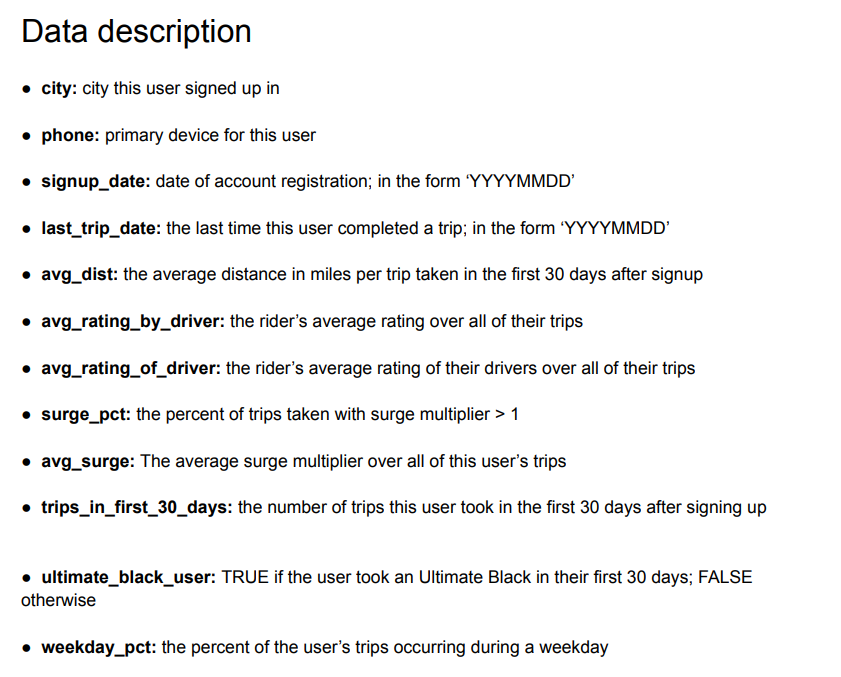

In [205]:
from IPython.display import Image
Image("features.png", width = 600, height = 300)

#### How much percentage of the data are active users: 

In [305]:
100-df['active_user'].sum()* 100 / df.shape[0]

75.59619078104994

In [306]:
active_user_pct =  pd.DataFrame({'Active_user':df['active_user'].sum()* 100 / df.shape[0], \
                           'not active_user':100-df['active_user'].sum()* 100 / df.shape[0]}, index=[0])

In [307]:
active_user_pct

,Active_user,not active_user
0,24.403809,75.596191


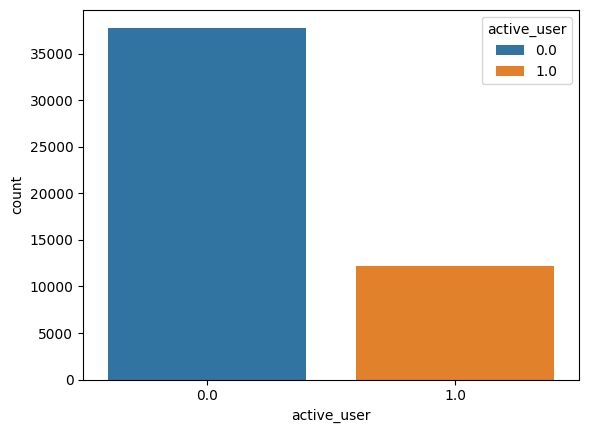

In [293]:
sns.countplot(df,x='active_user', hue='active_user')
plt.show()

Is the dataset imbalanced?

In [319]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
active_user               float64
dtype: object

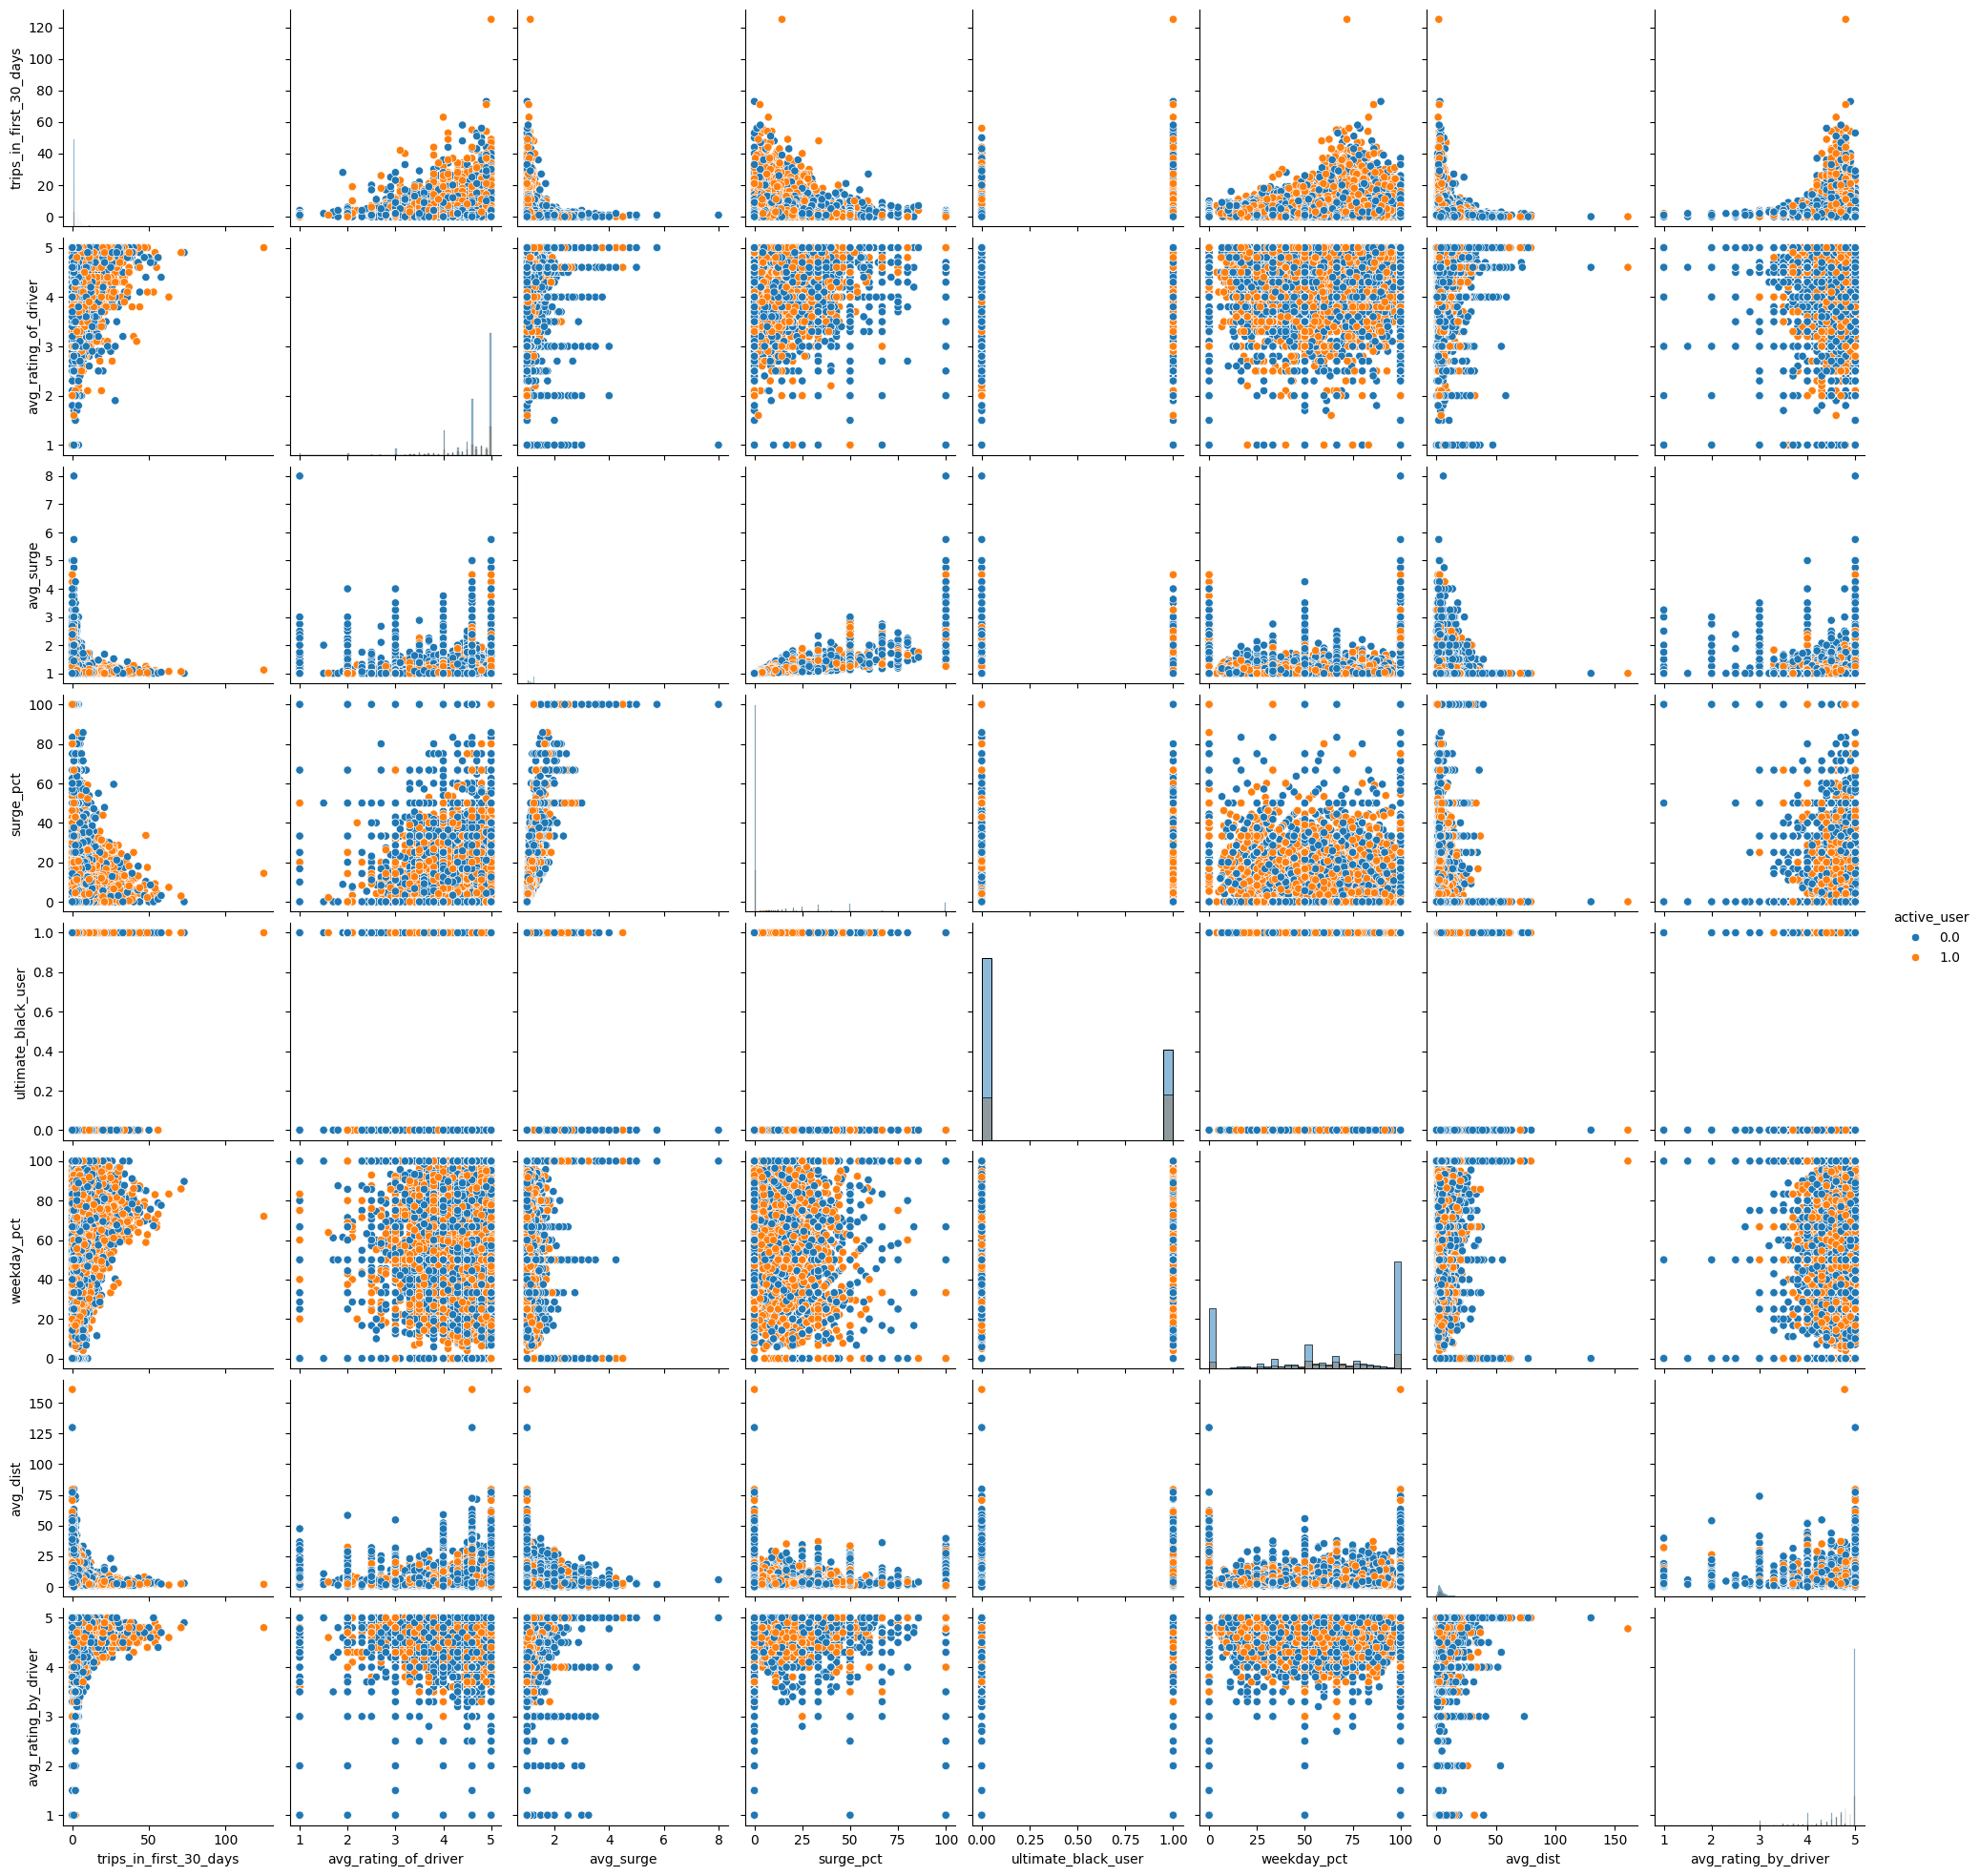

In [324]:
sns.pairplot(df, diag_kind="hist", hue='active_user')

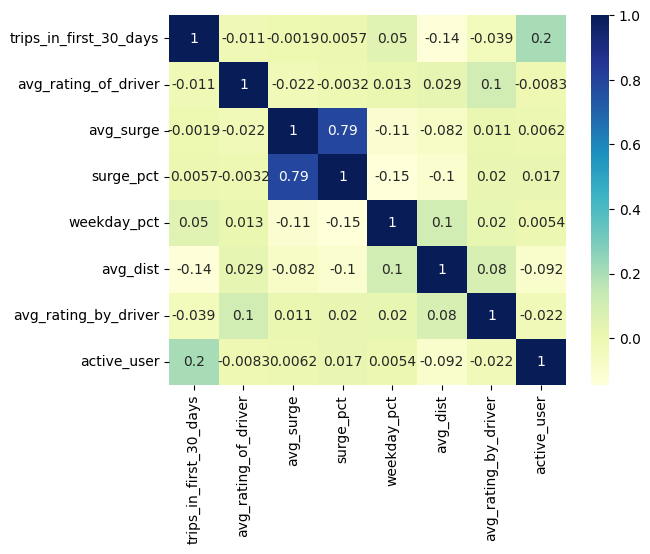

In [329]:
dataplot = sns.heatmap(df.select_dtypes(include='number').corr(), cmap="YlGnBu", annot=True) 
plt.show()

##### Effect of average distance on the retention of the rider

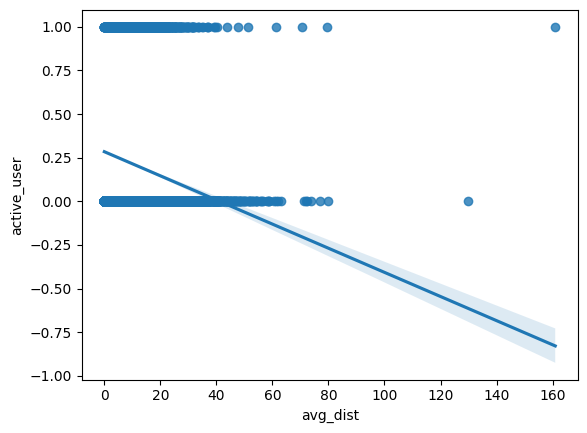

In [332]:
sns.regplot(y = df['active_user'], x = df['avg_dist'], fit_reg = True)
plt.show()

We can clearly see users are more likely to retain for shorter distances and would be most probably leaving for long distances

In [355]:
df_ = df.copy()

#### PART 3: PREPROCESSING (FEATURE ENGINEERING)

In [356]:
df_.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [357]:
df_.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
active_user               float64
dtype: object

Let's remove the date columns

In [358]:
df_ = df_.drop(columns=['signup_date', 'last_trip_date'])

In [367]:
# define X and Y variables
X = df_.drop(columns=['active_user'])
y = df_['active_user']
col_num = X.shape[1]

In [360]:
obj_cols = df_.select_dtypes(include=['object', 'bool']).columns
obj_cols

Index(['city', 'phone', 'ultimate_black_user'], dtype='object')

OneHot Encoding

In [380]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[obj_cols]).toarray())
feature_names = enc.get_feature_names_out()
enc_df.columns= feature_names
X.drop(columns=obj_cols, inplace=True)
X = X.join(enc_df)
print(X.columns)

Index(['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_Others', 'phone_iPhone',
       'ultimate_black_user_True'],
      dtype='object')


In [370]:
type(y)

pandas.core.series.Series

#### PART 3: MODELING

In [381]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Others,phone_iPhone,ultimate_black_user_True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [382]:
Xcol_names = X.columns
ycol_name =['active_user']

In [383]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

# Change back to panads dataframe
X_train = pd.DataFrame(X_train, columns=Xcol_names)
X_test = pd.DataFrame(X_test, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)
y_test = pd.DataFrame(y_test, columns=ycol_name)

In [447]:
ult_challenge = df.copy()

In [448]:
#from sklearn.model_selection import train_test_split

## extracting input and output
X = ult_challenge[ult_challenge.columns[:-1]]
y = ult_challenge[ult_challenge.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [449]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#### pipeline for categorical features
categorical_features = ["city", "phone", "ultimate_black_user"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

### pipeline for numeric features
numeric_features = ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

## setting up pipeline
preprocess = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features), ("cat", categorical_transformer, categorical_features)])

## random forest estimator
pipeline = Pipeline(steps = [("pre", preprocess), ("rf", RandomForestClassifier(random_state = 42))])

## some parameters for grid search
params = {"rf__n_estimators": [30,50,75],
          "rf__max_depth": [2, 3, 5]}

## fitting pipeline to grid search
cv = GridSearchCV(pipeline, param_grid = params, cv = 3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['avg_dist',
                                                                          'avg_rating_by_driver',
                                                                          'avg_rating_of_driver',
                                                                          'avg_surge',
                                                                          'surge_pct',
                                                                          'trips_in_first_30_days',
                                                                          'weekday_pct']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['city',
                                                                          'phone',
                                                                          'ultimate_black_user'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [2, 3, 5],
                         'rf__n_estimators': [30, 50, 75]})

In [450]:
print("Top parameters are: {}".format(cv.best_params_))
print("Accuracy from the best model is {}".format(cv.best_score_*100))

Top parameters are: {'rf__max_depth': 5, 'rf__n_estimators': 50}
Accuracy from the best model is 79.03566958317727


In [451]:
from sklearn import metrics

y_pred = cv.predict(X_test)

test_acc = metrics.accuracy_score(y_test, y_pred)
test_f1= metrics.f1_score(y_test, y_pred)

print("Accuracy of our model on test data is {}".format(test_acc*100))
print("F1 score of our model on test data is {}".format(test_f1))

Accuracy of our model on test data is 79.3744998666311
F1 score of our model on test data is 0.4202436738519213


In [452]:
pipeline.fit(X_train, y_train)

feat_weights = pipeline.named_steps['rf'].feature_importances_

# numeric columns
num_columns = ult_challenge[numeric_features].columns.values

# categorical columns
cat_columns = pd.get_dummies(ult_challenge[categorical_features]).columns.values

# total columns
tot_col = list(num_columns) + list(cat_columns)

In [453]:
# adding column names to the feature list
weight_dict = dict(zip(tot_col, feat_weights))

sorted_dict  = sorted(weight_dict.items(), key = lambda x: x[1], reverse = True)

In [458]:
sorted_dict

[('avg_dist', 0.2985233223953656),
 ('weekday_pct', 0.1483356415358827),
 ('avg_rating_by_driver', 0.10124690710593284),
 ('avg_rating_of_driver', 0.0950238797855206),
 ('surge_pct', 0.0944617474219131),
 ('trips_in_first_30_days', 0.08820550285758019),
 ('avg_surge', 0.08077596019539722),
 ('city_Astapor', 0.02228114685279192),
 ('city_Winterfell', 0.014707138282996269),
 ('ultimate_black_user', 0.012878455378331816),
 ('phone_Others', 0.011754494333032064),
 ('phone_iPhone', 0.010568653477132017),
 ("city_King's Landing", 0.008377555409476),
 ('phone_Android', 0.0011780709710338113)]

In [461]:
feature_importance = pd.DataFrame(sorted_dict, columns=['Features', 'Importance'])

Text(30.79308127572024, 0.5, 'Feature')

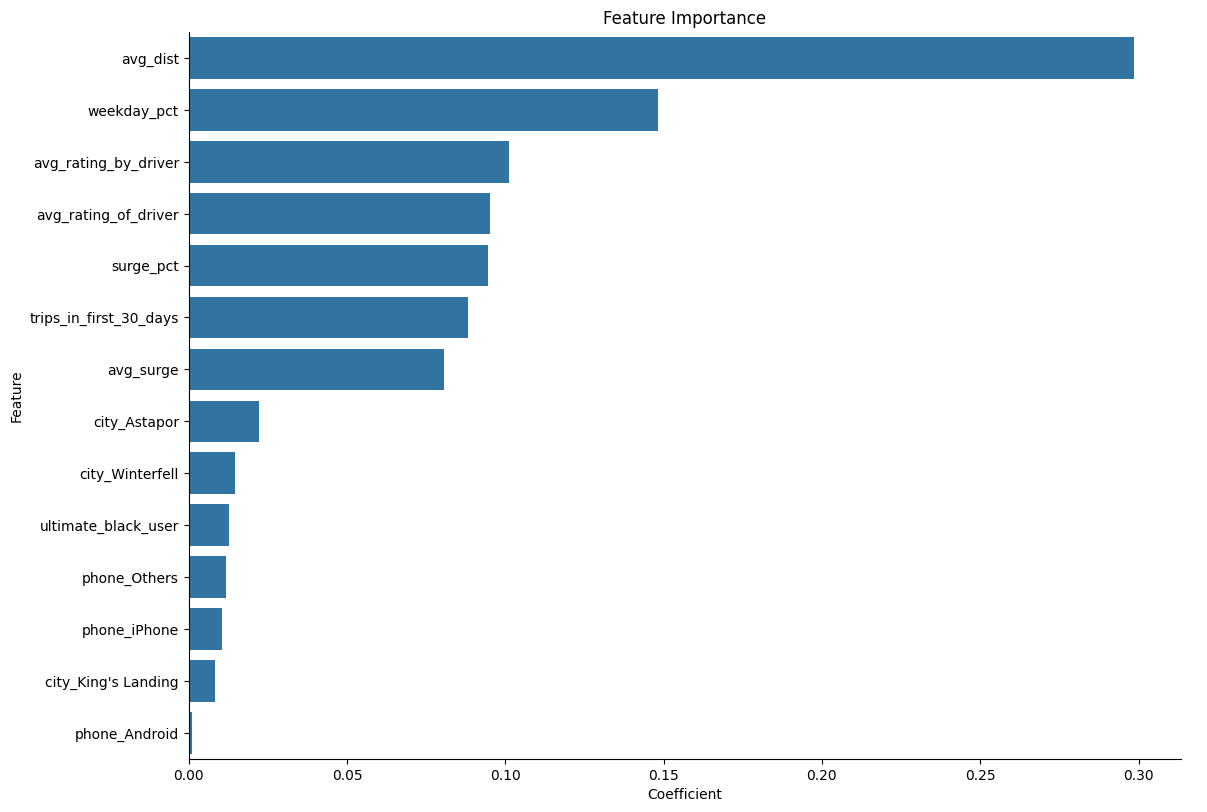

In [467]:
sns.catplot(y= feature_importance.Features, x='Importance', kind='bar', data=feature_importance, height=8, aspect=12/8)
plt.title('Feature Importance')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

#### PART 3: SUMMARY AND CONCLUSIONS

The analysis highlights that average distance holds the greatest significance among all features, closely followed by the weekday percentage. Additionally, it suggests that individuals from Astapor's Landing and those using other phones (not iPhones or android) exhibit a higher likelihood of retention, indicating noteworthy findings from the investigation.